In [1]:
"""
Data Exploration Script for Tour A and Tour B Comparative Analysis

This script performs exploratory data analysis (EDA) on power consumption data
from the SINERT project, focusing on comparing Tour A and Tour B buildings.

Meters/Counters Reference (from Metadonnees_13compteurs.pdf):
- TOUR_A_(TGBT_D14): Tour A - Lighting and power outlets
- Tour_B_(TGBT_D5): Tour B - Lighting and power outlets
- CLIM_TOUR_A_(TGBT_D6): Tour A - Heat pump/AC (currently Tour B climate)
- Additional Tour B rooms: B201, B112, B101

Author: Data Analysis Script
Date: November 2024
"""

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Set style for visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")


# ============================================================================
# 1. DATA LOADING FUNCTIONS
# ============================================================================

def get_csv_files(data_dir):
    """
    Dynamically find all CSV files in the data directory structure.
    
    Args:
        data_dir: Path to the SINERT_DATA_CONCENTRATOR directory
        
    Returns:
        List of paths to all CSV files
    """
    csv_files = []
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if file.endswith('.csv') or file.endswith('.xlsx'):
                csv_files.append(os.path.join(root, file))
    return sorted(csv_files)


def normalize_column_name(col_name):
    """
    Normalize column names by removing trailing numeric suffixes.
    
    XLSX files have numeric suffixes (e.g., 'TOUR_A_(TGBT_D14) kW sys (kW) [AVG] 877')
    while CSV files don't (e.g., 'TOUR_A_(TGBT_D14) kW sys (kW) [AVG] ')
    This function strips trailing numbers to ensure consistent column names.
    
    Args:
        col_name: Original column name
        
    Returns:
        Normalized column name
    """
    import re
    # Remove trailing whitespace and digits
    # Pattern: ends with optional whitespace and digits
    normalized = re.sub(r'\s*\d+$', '', str(col_name).strip())
    # Ensure trailing space for consistency with CSV files
    if not normalized.endswith(' ') and not normalized in ['Date', 'Time']:
        normalized = normalized + ' '
    return normalized


def load_single_csv(file_path):
    """
    Load a single CSV file and parse it correctly.
    
    Args:
        file_path: Path to the CSV file
        
    Returns:
        DataFrame with parsed data
    """
    try:
        if file_path.endswith('.csv'):
            df = pd.read_csv(file_path, sep=';', low_memory=False)
        elif file_path.endswith('.xlsx'):
            df = pd.read_excel(file_path)
            # convert Date column from yyyy-mm-dd hh:mm:ss to dd-mm-yyyy
            if 'Date' in df.columns and 'Time' in df.columns:
                df['Date'] = pd.to_datetime(df['Date']).dt.strftime('%d-%m-%Y')
            # Normalize column names to remove numeric suffixes
            df.columns = [normalize_column_name(col) for col in df.columns]
        else:
            print(f"❌ Unsupported file type: {file_path}")
            return None
        # Convert date and time columns
        if 'Date' in df.columns and 'Time' in df.columns:
            mask = ~(df['Time'] == '24:00:00')
            df = df[mask]
            df['Datetime'] = pd.to_datetime(
                df['Date'] + ' ' + df['Time'], 
                format='%d-%m-%Y %H:%M:%S',
                errors='coerce'
            )
            df.set_index('Datetime', inplace=True)
            df.drop(['Date', 'Time'], axis=1, inplace=True)
        return df
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None


def load_all_data(data_dir):
    csv_files = get_csv_files(data_dir)
    print(f"Found {len(csv_files)} CSV files")
    
    all_data = []
    for file_path in csv_files:
        df = load_single_csv(file_path)
        if df is not None:
            nat_count = df.index.isna().sum()
            if nat_count > 0:
                print(f"{file_path} has {nat_count} NaT rows")

            bad_index_values = []
            for idx in df.index:
                try:
                    pd.to_datetime(idx, errors='raise')
                except:
                    bad_index_values.append(idx)

            if bad_index_values:
                print(f"\n⚠️  Bad index values in {file_path}:")
                for v in bad_index_values[:20]:
                    print(f"   {repr(v)}")
                if len(bad_index_values) > 20:
                    print(f"   ... and {len(bad_index_values)-20} more")

            all_data.append(df)

    if all_data:
        combined_df = pd.concat(all_data, ignore_index=False)
        print(f"Total records loaded before fixing index: {len(combined_df)}")
        return combined_df

    return None


# ============================================================================
# 2. DATA EXTRACTION - TOUR A AND TOUR B
# ============================================================================

def get_tour_columns(df, tour):
    """
    Extract columns related to a specific tour.
    
    Args:
        df: DataFrame with all data
        tour: 'A' or 'B'
        
    Returns:
        List of column names for the specified tour
    """
    columns = df.columns.tolist()
    
    if tour.upper() == 'A':
        # Tour A main meter and climate
        prefixes = ['TOUR_A_(TGBT_D14)', 'CLIM_TOUR_A_(TGBT_D6)']
    elif tour.upper() == 'B':
        # Tour B main meter, heat pump, and room meters
        prefixes = ['Tour_B_(TGBT_D5)', 'SALLE_B101', 'SALLE_B112', 'SALLE_B201']
    else:
        return []
    
    tour_cols = []
    for col in columns:
        for prefix in prefixes:
            if col.startswith(prefix):
                tour_cols.append(col)
                break
    
    return tour_cols


def extract_tour_data(df, tour):
    """
    Extract data for a specific tour.
    
    Args:
        df: DataFrame with all data
        tour: 'A' or 'B'
        
    Returns:
        DataFrame with only tour-specific columns
    """
    tour_cols = get_tour_columns(df, tour)
    return df[tour_cols].copy()


def get_key_metrics_columns(df, tour):
    """
    Get the key metrics columns for power consumption analysis.
    
    Args:
        df: DataFrame with all data
        tour: 'A' or 'B'
        
    Returns:
        Dictionary with key metric column names
    """
    tour_cols = get_tour_columns(df, tour)
    
    metrics = {}
    
    # Priority order for power metrics - try main meter first, then specific ones
    power_priority = []
    energy_priority = []
    
    for col in tour_cols:
        col_lower = col.lower()
        # Check for main power metrics
        if 'kw sys' in col_lower and 'avg' in col_lower and 'kvar' not in col_lower:
            # Prioritize main meter (D14 for Tour A, D5 for Tour B)
            if 'tgbt_d14' in col_lower or 'tgbt_d5' in col_lower:
                power_priority.insert(0, col)
            else:
                power_priority.append(col)
        elif 'kwh' in col_lower and 'abs' in col_lower:
            if 'tgbt_d14' in col_lower or 'tgbt_d5' in col_lower:
                energy_priority.insert(0, col)
            else:
                energy_priority.append(col)
        elif 'kvar sys' in col_lower and 'avg' in col_lower:
            if 'reactive_power' not in metrics:
                metrics['reactive_power'] = col
        elif 'pf sys' in col_lower and 'avg' in col_lower:
            if 'power_factor' not in metrics:
                metrics['power_factor'] = col
        elif 'a l1' in col_lower and 'avg' in col_lower:
            if 'current_l1' not in metrics:
                metrics['current_l1'] = col
        elif 'a l2' in col_lower and 'avg' in col_lower:
            if 'current_l2' not in metrics:
                metrics['current_l2'] = col
        elif 'a l3' in col_lower and 'avg' in col_lower:
            if 'current_l3' not in metrics:
                metrics['current_l3'] = col
    
    # Select best power and energy columns
    if power_priority:
        metrics['power_avg'] = power_priority[0]
    if energy_priority:
        metrics['energy'] = energy_priority[0]
    
    return metrics


# ============================================================================
# 3. DATA CLEANING AND PREPROCESSING
# ============================================================================

def clean_numeric_data(df):
    """
    Clean and convert numeric data, handling special values.
    
    Args:
        df: DataFrame to clean
        
    Returns:
        Cleaned DataFrame with numeric columns
    """
    df_clean = df.copy()
    
    for col in df_clean.columns:
        # Replace '---' and empty strings with NaN
        df_clean[col] = df_clean[col].replace(['---', '', ' '], np.nan)
        
        # Convert to numeric
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
    
    return df_clean


def handle_missing_values(df, method='interpolate'):
    """
    Handle missing values in the DataFrame.
    
    Args:
        df: DataFrame with missing values
        method: Method to handle missing values ('interpolate', 'ffill', 'drop')
        
    Returns:
        DataFrame with handled missing values
    """
    # First, drop rows with NaT in index
    df_clean = df[df.index.notna()].copy()
    
    if method == 'interpolate':
        try:
            return df_clean.interpolate(method='time', limit=4)  # Limit to 1 hour (4 x 15min)
        except Exception:
            # Fallback to linear interpolation if time method fails
            return df_clean.interpolate(method='linear', limit=4)
    elif method == 'ffill':
        return df_clean.ffill(limit=4)
    elif method == 'drop':
        return df_clean.dropna()
    else:
        return df_clean


def get_data_quality_report(df):
    """
    Generate a data quality report.
    
    Args:
        df: DataFrame to analyze
        
    Returns:
        Dictionary with data quality metrics
    """
    report = {
        'total_records': len(df),
        'columns': len(df.columns),
        'missing_values': df.isnull().sum().sum(),
        'missing_percentage': (df.isnull().sum().sum() / (len(df) * len(df.columns))) * 100,
        'date_range': f"{df.index.min()} to {df.index.max()}" if len(df) > 0 else "N/A",
        'columns_with_missing': df.isnull().any().sum()
    }
    return report


def check_data_availability(df, tour, metrics):
    """
    Check data availability for a specific tour.
    
    Args:
        df: DataFrame with tour data
        tour: Tour name ('A' or 'B')
        metrics: Dictionary with metric column names
        
    Returns:
        Dictionary with data availability information
    """
    availability = {
        'tour': tour,
        'has_power_data': False,
        'power_data_count': 0,
        'power_data_pct': 0,
        'has_valid_readings': False,
        'issues': []
    }
    
    if 'power_avg' in metrics:
        power_col = metrics['power_avg']
        power_data = pd.to_numeric(df[power_col], errors='coerce')
        non_null_count = power_data.notna().sum()
        availability['power_data_count'] = non_null_count
        availability['power_data_pct'] = (non_null_count / len(df)) * 100 if len(df) > 0 else 0
        availability['has_power_data'] = non_null_count > 0
        
        # Check if readings are actually non-zero
        non_zero_count = (power_data > 0).sum()
        availability['non_zero_readings'] = non_zero_count
        availability['has_valid_readings'] = non_zero_count > 0
        
        if non_null_count == 0:
            availability['issues'].append("All power readings are missing (---)")
        elif non_zero_count == 0:
            availability['issues'].append("All power readings are zero (device may be off)")
    else:
        availability['issues'].append("No power column found in data")
    
    return availability


# ============================================================================
# 4. EXPLORATORY DATA ANALYSIS
# ============================================================================

def calculate_summary_statistics(df, tour_name):
    """
    Calculate summary statistics for power consumption.
    
    Args:
        df: DataFrame with tour data
        tour_name: Name of the tour for reporting
        
    Returns:
        DataFrame with summary statistics
    """
    # Get only numeric columns
    numeric_df = df.select_dtypes(include=[np.number])
    
    stats = numeric_df.describe().T
    stats['missing_count'] = numeric_df.isnull().sum()
    stats['missing_pct'] = (numeric_df.isnull().sum() / len(numeric_df)) * 100
    
    return stats


def analyze_power_consumption(df, metrics, tour_name):
    """
    Analyze power consumption patterns.
    
    Args:
        df: DataFrame with tour data
        metrics: Dictionary of key metric columns
        tour_name: Name of the tour
        
    Returns:
        Dictionary with consumption analysis results
    """
    results = {'tour': tour_name}
    
    if 'power_avg' in metrics:
        power_col = metrics['power_avg']
        power_data = pd.to_numeric(df[power_col], errors='coerce')
        
        results['avg_power_kw'] = power_data.mean()
        results['max_power_kw'] = power_data.max()
        results['min_power_kw'] = power_data[power_data > 0].min() if (power_data > 0).any() else 0
        results['std_power_kw'] = power_data.std()
        
        # Calculate total energy if available
        if 'energy' in metrics:
            energy_col = metrics['energy']
            energy_data = pd.to_numeric(df[energy_col], errors='coerce')
            if len(energy_data) > 0:
                results['total_energy_kwh'] = energy_data.iloc[-1] - energy_data.iloc[0]
    
    if 'power_factor' in metrics:
        pf_col = metrics['power_factor']
        pf_data = pd.to_numeric(df[pf_col], errors='coerce')
        results['avg_power_factor'] = pf_data.mean()
    
    return results


def analyze_temporal_patterns(df, power_col):
    """
    Analyze temporal patterns in power consumption.
    
    Args:
        df: DataFrame with datetime index
        power_col: Column name for power data
        
    Returns:
        Dictionary with temporal analysis results
    """
    power_data = pd.to_numeric(df[power_col], errors='coerce')
    
    # Add time components
    analysis_df = pd.DataFrame({
        'power': power_data,
        'hour': df.index.hour,
        'day_of_week': df.index.dayofweek,
        'is_weekend': df.index.dayofweek >= 5
    })
    
    results = {
        'hourly_avg': analysis_df.groupby('hour')['power'].mean().to_dict(),
        'daily_avg': analysis_df.groupby('day_of_week')['power'].mean().to_dict(),
        'weekday_avg': analysis_df[~analysis_df['is_weekend']]['power'].mean(),
        'weekend_avg': analysis_df[analysis_df['is_weekend']]['power'].mean()
    }
    
    return results


# ============================================================================
# 5. VISUALIZATIONS
# ============================================================================

def plot_power_comparison_timeseries(df_a, df_b, metrics_a, metrics_b, save_path=None):
    """
    Plot time series comparison of power consumption.
    """
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Power consumption over time
    if 'power_avg' in metrics_a and 'power_avg' in metrics_b:
        power_a = pd.to_numeric(df_a[metrics_a['power_avg']], errors='coerce')
        power_b = pd.to_numeric(df_b[metrics_b['power_avg']], errors='coerce')
        
        axes[0].plot(df_a.index, power_a, label='Tour A', alpha=0.7, linewidth=0.5)
        axes[0].plot(df_b.index, power_b, label='Tour B', alpha=0.7, linewidth=0.5)
        axes[0].set_xlabel('Date')
        axes[0].set_ylabel('Power (kW)')
        axes[0].set_title('Power Consumption Over Time - Tour A vs Tour B')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
    
    # Daily average comparison
    if 'power_avg' in metrics_a and 'power_avg' in metrics_b:
        power_a = pd.to_numeric(df_a[metrics_a['power_avg']], errors='coerce')
        power_b = pd.to_numeric(df_b[metrics_b['power_avg']], errors='coerce')
        
        daily_a = power_a.resample('D').mean()
        daily_b = power_b.resample('D').mean()
        
        axes[1].bar(daily_a.index, daily_a.values, alpha=0.6, label='Tour A', width=0.4)
        axes[1].bar(daily_b.index, daily_b.values, alpha=0.6, label='Tour B', width=0.4)
        axes[1].set_xlabel('Date')
        axes[1].set_ylabel('Average Daily Power (kW)')
        axes[1].set_title('Daily Average Power Consumption Comparison')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved: {save_path}")
    plt.close()


def plot_hourly_patterns(df_a, df_b, metrics_a, metrics_b, save_path=None):
    """
    Plot hourly consumption patterns.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    if 'power_avg' in metrics_a and 'power_avg' in metrics_b:
        power_a = pd.to_numeric(df_a[metrics_a['power_avg']], errors='coerce')
        power_b = pd.to_numeric(df_b[metrics_b['power_avg']], errors='coerce')
        
        hourly_a = power_a.groupby(df_a.index.hour).mean()
        hourly_b = power_b.groupby(df_b.index.hour).mean()
        
        # Bar chart
        x = np.arange(24)
        width = 0.35
        
        axes[0].bar(x - width/2, hourly_a.values, width, label='Tour A', alpha=0.8)
        axes[0].bar(x + width/2, hourly_b.values, width, label='Tour B', alpha=0.8)
        axes[0].set_xlabel('Hour of Day')
        axes[0].set_ylabel('Average Power (kW)')
        axes[0].set_title('Hourly Power Consumption Pattern')
        axes[0].set_xticks(x)
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Difference plot
        diff = hourly_b.values - hourly_a.values
        colors = ['green' if d > 0 else 'red' for d in diff]
        axes[1].bar(x, diff, color=colors, alpha=0.7)
        axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
        axes[1].set_xlabel('Hour of Day')
        axes[1].set_ylabel('Power Difference (kW)')
        axes[1].set_title('Hourly Power Difference (Tour B - Tour A)\nGreen: Tour B uses more | Red: Tour A uses more')
        axes[1].set_xticks(x)
        axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved: {save_path}")
    plt.close()


def plot_distribution_comparison(df_a, df_b, metrics_a, metrics_b, save_path=None):
    """
    Plot distribution comparison of power consumption.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    if 'power_avg' in metrics_a and 'power_avg' in metrics_b:
        power_a = pd.to_numeric(df_a[metrics_a['power_avg']], errors='coerce').dropna()
        power_b = pd.to_numeric(df_b[metrics_b['power_avg']], errors='coerce').dropna()
        
        # Histogram
        axes[0].hist(power_a, bins=50, alpha=0.6, label='Tour A', density=True)
        axes[0].hist(power_b, bins=50, alpha=0.6, label='Tour B', density=True)
        axes[0].set_xlabel('Power (kW)')
        axes[0].set_ylabel('Density')
        axes[0].set_title('Distribution of Power Consumption')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Box plot
        data = [power_a.values, power_b.values]
        bp = axes[1].boxplot(data, labels=['Tour A', 'Tour B'], patch_artist=True)
        colors = ['steelblue', 'coral']
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.6)
        axes[1].set_ylabel('Power (kW)')
        axes[1].set_title('Power Consumption Distribution Comparison')
        axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved: {save_path}")
    plt.close()


def plot_weekly_patterns(df_a, df_b, metrics_a, metrics_b, save_path=None):
    """
    Plot weekly consumption patterns.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    
    if 'power_avg' in metrics_a and 'power_avg' in metrics_b:
        power_a = pd.to_numeric(df_a[metrics_a['power_avg']], errors='coerce')
        power_b = pd.to_numeric(df_b[metrics_b['power_avg']], errors='coerce')
        
        weekly_a = power_a.groupby(df_a.index.dayofweek).mean()
        weekly_b = power_b.groupby(df_b.index.dayofweek).mean()
        
        # Bar chart
        x = np.arange(7)
        width = 0.35
        
        axes[0].bar(x - width/2, weekly_a.values, width, label='Tour A', alpha=0.8)
        axes[0].bar(x + width/2, weekly_b.values, width, label='Tour B', alpha=0.8)
        axes[0].set_xlabel('Day of Week')
        axes[0].set_ylabel('Average Power (kW)')
        axes[0].set_title('Weekly Power Consumption Pattern')
        axes[0].set_xticks(x)
        axes[0].set_xticklabels(days, rotation=45)
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Weekday vs Weekend
        weekday_a = power_a[df_a.index.dayofweek < 5].mean()
        weekend_a = power_a[df_a.index.dayofweek >= 5].mean()
        weekday_b = power_b[df_b.index.dayofweek < 5].mean()
        weekend_b = power_b[df_b.index.dayofweek >= 5].mean()
        
        x = np.arange(2)
        width = 0.35
        
        axes[1].bar(x - width/2, [weekday_a, weekend_a], width, label='Tour A', alpha=0.8)
        axes[1].bar(x + width/2, [weekday_b, weekend_b], width, label='Tour B', alpha=0.8)
        axes[1].set_xlabel('Period')
        axes[1].set_ylabel('Average Power (kW)')
        axes[1].set_title('Weekday vs Weekend Power Consumption')
        axes[1].set_xticks(x)
        axes[1].set_xticklabels(['Weekday', 'Weekend'])
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved: {save_path}")
    plt.close()


def plot_energy_efficiency_comparison(results_a, results_b, save_path=None):
    """
    Plot energy efficiency comparison metrics.
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Average Power Comparison
    tours = ['Tour A', 'Tour B']
    avg_power = [results_a.get('avg_power_kw', 0), results_b.get('avg_power_kw', 0)]
    colors = ['steelblue', 'coral']
    
    axes[0].bar(tours, avg_power, color=colors, alpha=0.8)
    axes[0].set_ylabel('Average Power (kW)')
    axes[0].set_title('Average Power Consumption')
    for i, v in enumerate(avg_power):
        axes[0].text(i, v + 0.01 * max(avg_power), f'{v:.2f}', ha='center', fontsize=10)
    axes[0].grid(True, alpha=0.3)
    
    # Max Power Comparison
    max_power = [results_a.get('max_power_kw', 0), results_b.get('max_power_kw', 0)]
    
    axes[1].bar(tours, max_power, color=colors, alpha=0.8)
    axes[1].set_ylabel('Maximum Power (kW)')
    axes[1].set_title('Peak Power Consumption')
    for i, v in enumerate(max_power):
        axes[1].text(i, v + 0.01 * max(max_power), f'{v:.2f}', ha='center', fontsize=10)
    axes[1].grid(True, alpha=0.3)
    
    # Power Factor Comparison
    pf = [results_a.get('avg_power_factor', 0), results_b.get('avg_power_factor', 0)]
    
    axes[2].bar(tours, pf, color=colors, alpha=0.8)
    axes[2].set_ylabel('Average Power Factor')
    axes[2].set_title('Power Factor Comparison')
    axes[2].set_ylim(0, 1.1)
    for i, v in enumerate(pf):
        if pd.notna(v):
            axes[2].text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=10)
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved: {save_path}")
    plt.close()


def plot_cumulative_energy(df_a, df_b, metrics_a, metrics_b, save_path=None):
    """
    Plot cumulative energy consumption over time.
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    
    if 'power_avg' in metrics_a and 'power_avg' in metrics_b:
        power_a = pd.to_numeric(df_a[metrics_a['power_avg']], errors='coerce').fillna(0)
        power_b = pd.to_numeric(df_b[metrics_b['power_avg']], errors='coerce').fillna(0)
        
        # Convert to kWh (power * time interval in hours)
        # Assuming 15-minute intervals = 0.25 hours
        energy_a = (power_a * 0.25).cumsum()
        energy_b = (power_b * 0.25).cumsum()
        
        ax.plot(df_a.index, energy_a, label='Tour A', linewidth=2)
        ax.plot(df_b.index, energy_b, label='Tour B', linewidth=2)
        ax.set_xlabel('Date')
        ax.set_ylabel('Cumulative Energy (kWh)')
        ax.set_title('Cumulative Energy Consumption Over Time')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Add final values annotation
        if len(energy_a) > 0 and len(energy_b) > 0:
            ax.annotate(f'Tour A: {energy_a.iloc[-1]:.1f} kWh', 
                       xy=(df_a.index[-1], energy_a.iloc[-1]),
                       xytext=(10, 0), textcoords='offset points', fontsize=10)
            ax.annotate(f'Tour B: {energy_b.iloc[-1]:.1f} kWh', 
                       xy=(df_b.index[-1], energy_b.iloc[-1]),
                       xytext=(10, 0), textcoords='offset points', fontsize=10)
    
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved: {save_path}")
    plt.close()


# ============================================================================
# 6. SUMMARY AND INSIGHTS
# ============================================================================

def generate_insights(results_a, results_b, temporal_a, temporal_b, availability_a=None, availability_b=None):
    """
    Generate insights from the analysis.
    
    Args:
        results_a: Analysis results for Tour A
        results_b: Analysis results for Tour B
        temporal_a: Temporal analysis for Tour A
        temporal_b: Temporal analysis for Tour B
        availability_a: Data availability info for Tour A
        availability_b: Data availability info for Tour B
        
    Returns:
        String with formatted insights
    """
    insights = []
    insights.append("=" * 60)
    insights.append("COMPARATIVE ANALYSIS INSIGHTS: TOUR A vs TOUR B")
    insights.append("=" * 60)
    
    # Data availability notice
    insights.append("\n0. DATA AVAILABILITY STATUS:")
    if availability_a:
        if availability_a.get('has_valid_readings', False):
            insights.append(f"   - Tour A: Data available ({availability_a.get('power_data_pct', 0):.1f}% coverage)")
        else:
            insights.append(f"   - Tour A: LIMITED DATA - {', '.join(availability_a.get('issues', ['Unknown issue']))}")
    if availability_b:
        if availability_b.get('has_valid_readings', False):
            insights.append(f"   - Tour B: Data available ({availability_b.get('power_data_pct', 0):.1f}% coverage)")
        else:
            insights.append(f"   - Tour B: LIMITED DATA - {', '.join(availability_b.get('issues', ['Unknown issue']))}")
    
    # Power consumption comparison
    avg_a = results_a.get('avg_power_kw', 0) or 0
    avg_b = results_b.get('avg_power_kw', 0) or 0
    
    insights.append(f"\n1. AVERAGE POWER CONSUMPTION:")
    insights.append(f"   - Tour A: {avg_a:.2f} kW")
    insights.append(f"   - Tour B: {avg_b:.2f} kW")
    
    if avg_a > 0 and avg_b > 0:
        diff_pct = ((avg_b - avg_a) / avg_a) * 100
        insights.append(f"   - Difference: Tour B uses {abs(diff_pct):.1f}% {'more' if diff_pct > 0 else 'less'} power than Tour A")
    elif avg_b > 0 and avg_a == 0:
        insights.append(f"   - Note: Tour A shows no active power consumption (device may be off or data missing)")
    
    # Peak power comparison
    max_a = results_a.get('max_power_kw', 0) or 0
    max_b = results_b.get('max_power_kw', 0) or 0
    
    insights.append(f"\n2. PEAK POWER CONSUMPTION:")
    insights.append(f"   - Tour A peak: {max_a:.2f} kW")
    insights.append(f"   - Tour B peak: {max_b:.2f} kW")
    if max_a > 0 and max_b > 0:
        insights.append(f"   - {'Tour B' if max_b > max_a else 'Tour A'} has higher peak demand")
    
    # Power factor comparison
    pf_a = results_a.get('avg_power_factor', None)
    pf_b = results_b.get('avg_power_factor', None)
    
    insights.append(f"\n3. POWER FACTOR (EFFICIENCY INDICATOR):")
    if pf_a is not None and pd.notna(pf_a):
        insights.append(f"   - Tour A: {pf_a:.3f}")
    else:
        insights.append(f"   - Tour A: Not available")
    if pf_b is not None and pd.notna(pf_b):
        insights.append(f"   - Tour B: {pf_b:.3f}")
    else:
        insights.append(f"   - Tour B: Not available")
    
    if pf_a and pf_b and pd.notna(pf_a) and pd.notna(pf_b):
        insights.append(f"   - {'Tour A' if abs(pf_a) > abs(pf_b) else 'Tour B'} has better power factor")
    
    # Weekday vs Weekend patterns
    insights.append(f"\n4. WEEKDAY vs WEEKEND PATTERNS:")
    if temporal_a:
        insights.append(f"   Tour A:")
        insights.append(f"      - Weekday avg: {temporal_a.get('weekday_avg', 0):.2f} kW")
        insights.append(f"      - Weekend avg: {temporal_a.get('weekend_avg', 0):.2f} kW")
    if temporal_b:
        insights.append(f"   Tour B:")
        insights.append(f"      - Weekday avg: {temporal_b.get('weekday_avg', 0):.2f} kW")
        insights.append(f"      - Weekend avg: {temporal_b.get('weekend_avg', 0):.2f} kW")
        
        if temporal_b.get('weekday_avg', 0) > 0 and temporal_b.get('weekend_avg', 0) > 0:
            wkday_vs_wknd = ((temporal_b['weekday_avg'] - temporal_b['weekend_avg']) / temporal_b['weekend_avg']) * 100
            insights.append(f"      - Tour B weekday consumption is {abs(wkday_vs_wknd):.1f}% {'higher' if wkday_vs_wknd > 0 else 'lower'} than weekend")
    
    # Energy efficiency summary
    insights.append(f"\n5. ENERGY EFFICIENCY SUMMARY:")
    if avg_a > 0 and avg_b > 0:
        more_efficient = 'Tour A' if avg_a < avg_b else 'Tour B'
        insights.append(f"   - {more_efficient} is more energy efficient based on average consumption")
    elif avg_b > 0:
        insights.append(f"   - Tour B is actively consuming power with average of {avg_b:.2f} kW")
        insights.append(f"   - Tour A comparison not possible due to missing/zero data")
    
    # Key findings
    insights.append(f"\n6. KEY FINDINGS:")
    if avg_b > 0:
        # Calculate estimated daily consumption for Tour B
        daily_kwh_b = avg_b * 24
        monthly_kwh_b = daily_kwh_b * 30
        insights.append(f"   - Tour B estimated daily consumption: {daily_kwh_b:.1f} kWh")
        insights.append(f"   - Tour B estimated monthly consumption: {monthly_kwh_b:.1f} kWh")
    
    if temporal_b:
        # Find peak hours
        hourly_avg = temporal_b.get('hourly_avg', {})
        if hourly_avg:
            peak_hour = max(hourly_avg, key=hourly_avg.get)
            min_hour = min(hourly_avg, key=hourly_avg.get)
            insights.append(f"   - Tour B peak consumption hour: {peak_hour}:00 ({hourly_avg[peak_hour]:.2f} kW)")
            insights.append(f"   - Tour B minimum consumption hour: {min_hour}:00 ({hourly_avg[min_hour]:.2f} kW)")
    
    insights.append("\n" + "=" * 60)
    
    return "\n".join(insights)

In [2]:
"""
Data Exploration V2 Script for Tour A and Tour B Comparative Analysis

This enhanced version adds:
- Monthly trend analysis
- Seasonal comparisons
- Load factor analysis
- Peak demand analysis
- Energy cost estimation
- Power quality metrics
- Comprehensive JSON export for React dashboard

Author: Data Analysis Script
Date: November 2024
"""

import os
import re
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime

warnings.filterwarnings('ignore')

# Set style for visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")


# ============================================================================
# 1. DATA LOADING FUNCTIONS (with column name normalization)
# ============================================================================

def normalize_column_name(col_name):
    """
    Normalize column names by removing trailing numeric suffixes.
    """
    normalized = re.sub(r'\s*\d+$', '', str(col_name).strip())
    if not normalized.endswith(' ') and normalized not in ['Date', 'Time']:
        normalized = normalized + ' '
    return normalized


def get_csv_files(data_dir):
    """Find all CSV and XLSX files in the data directory structure."""
    csv_files = []
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            if file.endswith('.csv') or file.endswith('.xlsx'):
                csv_files.append(os.path.join(root, file))
    return sorted(csv_files)


def load_single_file(file_path):
    """Load a single CSV/XLSX file with proper parsing."""
    try:
        if file_path.endswith('.csv'):
            df = pd.read_csv(file_path, sep=';', low_memory=False)
        elif file_path.endswith('.xlsx'):
            df = pd.read_excel(file_path)
            if 'Date' in df.columns:
                df['Date'] = pd.to_datetime(df['Date']).dt.strftime('%d-%m-%Y')
            df.columns = [normalize_column_name(col) for col in df.columns]
        else:
            return None
            
        if 'Date' in df.columns and 'Time' in df.columns:
            mask = ~(df['Time'] == '24:00:00')
            df = df[mask]
            df['Datetime'] = pd.to_datetime(
                df['Date'] + ' ' + df['Time'], 
                format='%d-%m-%Y %H:%M:%S',
                errors='coerce'
            )
            df.set_index('Datetime', inplace=True)
            df.drop(['Date', 'Time'], axis=1, inplace=True)
        return df
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None


def load_all_data(data_dir):
    """Load all data files and combine them."""
    csv_files = get_csv_files(data_dir)
    print(f"Found {len(csv_files)} files")
    
    all_data = []
    for file_path in csv_files:
        df = load_single_file(file_path)
        if df is not None:
            all_data.append(df)
    
    if all_data:
        combined_df = pd.concat(all_data, ignore_index=False)
        combined_df = combined_df[combined_df.index.notna()]
        combined_df = combined_df.sort_index()
        print(f"Total records loaded: {len(combined_df)}")
        return combined_df
    return None


# ============================================================================
# 2. DATA EXTRACTION - TOUR A AND TOUR B
# ============================================================================

def get_tour_columns(df, tour):
    """Extract columns related to a specific tour."""
    columns = df.columns.tolist()
    
    if tour.upper() == 'A':
        prefixes = ['TOUR_A_(TGBT_D14)', 'CLIM_TOUR_A_(TGBT_D6)']
    elif tour.upper() == 'B':
        prefixes = ['Tour_B_(TGBT_D5)', 'SALLE_B101', 'SALLE_B112', 'SALLE_B201']
    else:
        return []
    
    tour_cols = []
    for col in columns:
        for prefix in prefixes:
            if col.startswith(prefix):
                tour_cols.append(col)
                break
    return tour_cols


def get_power_column(df, tour):
    """Get the main power consumption column for a tour."""
    tour_cols = get_tour_columns(df, tour)
    for col in tour_cols:
        col_lower = col.lower()
        if 'kw sys' in col_lower and 'avg' in col_lower and 'kvar' not in col_lower:
            if (tour.upper() == 'A' and 'tgbt_d14' in col_lower) or \
               (tour.upper() == 'B' and 'tgbt_d5' in col_lower):
                return col
    return None


def clean_power_data(df, power_col):
    """Clean power data by removing outliers and handling missing values."""
    power = pd.to_numeric(df[power_col], errors='coerce')
    
    # Remove extreme outliers (> 3 standard deviations or above 50 kW for these buildings)
    mean_power = power.mean()
    std_power = power.std()
    upper_limit = min(mean_power + 3 * std_power, 50)  # Cap at 50 kW
    power = power.where(power <= upper_limit, np.nan)
    
    return power


# ============================================================================
# 3. ENHANCED ANALYSIS FUNCTIONS
# ============================================================================

def calculate_monthly_stats(power_series, name):
    """Calculate monthly statistics."""
    monthly = power_series.resample('M').agg(['mean', 'max', 'min', 'std', 'count'])
    monthly.columns = [f'{name}_{c}' for c in monthly.columns]
    return monthly


def calculate_hourly_patterns(power_series):
    """Calculate hourly consumption patterns."""
    hourly = power_series.groupby(power_series.index.hour).agg(['mean', 'std', 'max', 'min'])
    return hourly


def calculate_weekly_patterns(power_series):
    """Calculate weekly consumption patterns."""
    daily_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    weekly = power_series.groupby(power_series.index.dayofweek).agg(['mean', 'std'])
    weekly.index = daily_names
    return weekly


def calculate_load_factor(power_series):
    """
    Calculate load factor = Average Load / Peak Load
    Higher load factor means more efficient use of peak capacity.
    """
    avg_load = power_series.mean()
    peak_load = power_series.max()
    if peak_load > 0:
        return avg_load / peak_load
    return 0


def calculate_peak_to_average_ratio(power_series):
    """Calculate peak-to-average ratio (PAR)."""
    avg = power_series.mean()
    peak = power_series.max()
    if avg > 0:
        return peak / avg
    return 0


def estimate_energy_consumption(power_series, interval_hours=0.25):
    """Estimate total energy consumption in kWh."""
    # Each reading represents 15 minutes = 0.25 hours
    energy = (power_series.fillna(0) * interval_hours).sum()
    return energy


def analyze_peak_hours(power_series, top_n=5):
    """Find peak consumption hours."""
    hourly_avg = power_series.groupby(power_series.index.hour).mean()
    peak_hours = hourly_avg.nlargest(top_n)
    return peak_hours


def analyze_off_peak_hours(power_series, bottom_n=5):
    """Find off-peak consumption hours."""
    hourly_avg = power_series.groupby(power_series.index.hour).mean()
    off_peak_hours = hourly_avg.nsmallest(bottom_n)
    return off_peak_hours


def compare_seasonal_patterns(power_a, power_b):
    """Compare seasonal consumption patterns by month."""
    # Group by month name
    month_order = ['January', 'February', 'March', 'April', 'May', 'June',
                   'July', 'August', 'September', 'October', 'November', 'December']
    
    a_monthly = power_a.groupby(power_a.index.month).mean()
    b_monthly = power_b.groupby(power_b.index.month).mean()
    
    # Convert to month names
    a_monthly.index = [month_order[i-1] for i in a_monthly.index]
    b_monthly.index = [month_order[i-1] for i in b_monthly.index]
    
    return pd.DataFrame({'Tour A': a_monthly, 'Tour B': b_monthly})


# ============================================================================
# 4. VISUALIZATION FUNCTIONS
# ============================================================================

def plot_monthly_comparison(power_a, power_b, save_path=None):
    """Plot monthly consumption comparison."""
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Monthly averages
    monthly_a = power_a.resample('M').mean()
    monthly_b = power_b.resample('M').mean()
    
    # Bar chart
    x = np.arange(len(monthly_a))
    width = 0.35
    
    axes[0].bar(x - width/2, monthly_a.values, width, label='Tour A', alpha=0.8, color='#FF6B6B')
    axes[0].bar(x + width/2, monthly_b.values, width, label='Tour B', alpha=0.8, color='#4ECDC4')
    axes[0].set_xlabel('Month')
    axes[0].set_ylabel('Average Power (kW)')
    axes[0].set_title('Monthly Average Power Consumption')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels([d.strftime('%b %Y') for d in monthly_a.index], rotation=45)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Monthly total energy
    monthly_energy_a = (power_a.resample('M').mean() * 24 * power_a.resample('M').count() / 96)
    monthly_energy_b = (power_b.resample('M').mean() * 24 * power_b.resample('M').count() / 96)
    
    axes[1].plot(monthly_energy_a.index, monthly_energy_a.values, 'o-', 
                 label='Tour A', color='#FF6B6B', linewidth=2, markersize=8)
    axes[1].plot(monthly_energy_b.index, monthly_energy_b.values, 's-', 
                 label='Tour B', color='#4ECDC4', linewidth=2, markersize=8)
    axes[1].set_xlabel('Month')
    axes[1].set_ylabel('Estimated Energy (kWh)')
    axes[1].set_title('Monthly Energy Consumption Trend')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved: {save_path}")
    plt.close()


def plot_heatmap_comparison(power_a, power_b, save_path=None):
    """Plot hourly consumption heatmaps for both tours."""
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Create hour vs day of week pivot tables
    df_a = pd.DataFrame({'power': power_a, 'hour': power_a.index.hour, 'day': power_a.index.dayofweek})
    df_b = pd.DataFrame({'power': power_b, 'hour': power_b.index.hour, 'day': power_b.index.dayofweek})
    
    pivot_a = df_a.pivot_table(values='power', index='day', columns='hour', aggfunc='mean')
    pivot_b = df_b.pivot_table(values='power', index='day', columns='hour', aggfunc='mean')
    
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    
    # Determine common scale
    vmin = min(pivot_a.min().min(), pivot_b.min().min())
    vmax = max(pivot_a.max().max(), pivot_b.max().max())
    
    sns.heatmap(pivot_a, ax=axes[0], cmap='YlOrRd', vmin=vmin, vmax=vmax,
                yticklabels=days, cbar_kws={'label': 'Power (kW)'})
    axes[0].set_title('Tour A - Hourly Consumption Pattern')
    axes[0].set_xlabel('Hour of Day')
    axes[0].set_ylabel('Day of Week')
    
    sns.heatmap(pivot_b, ax=axes[1], cmap='YlGnBu', vmin=vmin, vmax=vmax,
                yticklabels=days, cbar_kws={'label': 'Power (kW)'})
    axes[1].set_title('Tour B - Hourly Consumption Pattern')
    axes[1].set_xlabel('Hour of Day')
    axes[1].set_ylabel('Day of Week')
    
    plt.tight_layout()
    plt.show()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved: {save_path}")
    plt.close()


def plot_efficiency_metrics(metrics_a, metrics_b, save_path=None):
    """Plot efficiency metrics comparison."""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    colors = ['#FF6B6B', '#4ECDC4']
    
    # Load Factor
    ax = axes[0, 0]
    bars = ax.bar(['Tour A', 'Tour B'], 
                   [metrics_a['load_factor'], metrics_b['load_factor']], 
                   color=colors, alpha=0.8)
    ax.set_ylabel('Load Factor')
    ax.set_title('Load Factor Comparison\n(Higher = Better Utilization)')
    ax.set_ylim(0, 1)
    for bar, val in zip(bars, [metrics_a['load_factor'], metrics_b['load_factor']]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                f'{val:.2f}', ha='center', fontsize=12)
    ax.grid(True, alpha=0.3)
    
    # Peak to Average Ratio
    ax = axes[0, 1]
    bars = ax.bar(['Tour A', 'Tour B'], 
                   [metrics_a['peak_to_avg'], metrics_b['peak_to_avg']], 
                   color=colors, alpha=0.8)
    ax.set_ylabel('Peak/Average Ratio')
    ax.set_title('Peak-to-Average Ratio\n(Lower = More Consistent Load)')
    for bar, val in zip(bars, [metrics_a['peak_to_avg'], metrics_b['peak_to_avg']]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                f'{val:.2f}', ha='center', fontsize=12)
    ax.grid(True, alpha=0.3)
    
    # Total Energy
    ax = axes[1, 0]
    bars = ax.bar(['Tour A', 'Tour B'], 
                   [metrics_a['total_energy_kwh'], metrics_b['total_energy_kwh']], 
                   color=colors, alpha=0.8)
    ax.set_ylabel('Total Energy (kWh)')
    ax.set_title('Total Energy Consumption')
    for bar, val in zip(bars, [metrics_a['total_energy_kwh'], metrics_b['total_energy_kwh']]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
                f'{val:.0f}', ha='center', fontsize=12)
    ax.grid(True, alpha=0.3)
    
    # Weekday vs Weekend
    ax = axes[1, 1]
    x = np.arange(2)
    width = 0.35
    ax.bar(x - width/2, [metrics_a['weekday_avg'], metrics_a['weekend_avg']], 
           width, label='Tour A', color=colors[0], alpha=0.8)
    ax.bar(x + width/2, [metrics_b['weekday_avg'], metrics_b['weekend_avg']], 
           width, label='Tour B', color=colors[1], alpha=0.8)
    ax.set_ylabel('Average Power (kW)')
    ax.set_title('Weekday vs Weekend Consumption')
    ax.set_xticks(x)
    ax.set_xticklabels(['Weekday', 'Weekend'])
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved: {save_path}")
    plt.close()


def plot_peak_analysis(power_a, power_b, save_path=None):
    """Plot peak demand analysis."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Peak hours analysis
    peak_a = analyze_peak_hours(power_a, 10)
    peak_b = analyze_peak_hours(power_b, 10)
    
    ax = axes[0]
    width = 0.35
    x = np.arange(10)
    ax.bar(x - width/2, peak_a.values, width, label='Tour A', color='#FF6B6B', alpha=0.8)
    ax.bar(x + width/2, peak_b.values, width, label='Tour B', color='#4ECDC4', alpha=0.8)
    ax.set_xlabel('Hour (Ranked by Consumption)')
    ax.set_ylabel('Average Power (kW)')
    ax.set_title('Top 10 Peak Consumption Hours')
    ax.set_xticks(x)
    ax.set_xticklabels([f'{h}:00' for h in peak_a.index])
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Daily peaks
    ax = axes[1]
    daily_max_a = power_a.resample('D').max()
    daily_max_b = power_b.resample('D').max()
    
    ax.hist(daily_max_a.dropna(), bins=20, alpha=0.6, label='Tour A', color='#FF6B6B')
    ax.hist(daily_max_b.dropna(), bins=20, alpha=0.6, label='Tour B', color='#4ECDC4')
    ax.set_xlabel('Daily Peak Power (kW)')
    ax.set_ylabel('Frequency')
    ax.set_title('Distribution of Daily Peak Power')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved: {save_path}")
    plt.close()

In [3]:

"""
Main function to run the complete data exploration analysis.
"""
print("=" * 60)
print("DATA EXPLORATION: Tour A and Tour B Comparative Analysis")
print("=" * 60)

# Define paths
base_dir = './'
data_dir = os.path.join(base_dir, "SINERT_DATA_CONCENTRATOR")
output_dir = os.path.join(base_dir, "exploration_output")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# =========================================
# Step 1: Load all data
# =========================================
print("\n[1/6] Loading data from CSV files...")
df = load_all_data(data_dir)

if df is None or len(df) == 0:
    print("Error: No data could be loaded!")
    exit(1)

# Sort by index and drop rows with NaT in index
df = df[df.index.notna()]
df = df.sort_index()


print(f"Data loaded: {len(df)} records, {len(df.columns)} columns")
print(f"Date range: {df.index.min()} to {df.index.max()}")

# =========================================
# Step 2: Extract Tour A and Tour B data
# =========================================
print("\n[2/6] Extracting Tour A and Tour B data...")

tour_a_cols = get_tour_columns(df, 'A')
tour_b_cols = get_tour_columns(df, 'B')

print(f"Tour A columns: {len(tour_a_cols)}")
print(f"Tour B columns: {len(tour_b_cols)}")

df_tour_a = extract_tour_data(df, 'A')
df_tour_b = extract_tour_data(df, 'B')

metrics_a = get_key_metrics_columns(df, 'A')
metrics_b = get_key_metrics_columns(df, 'B')

print(f"\nTour A key metrics: {list(metrics_a.keys())}")
print(f"Tour B key metrics: {list(metrics_b.keys())}")

# =========================================
# Step 3: Data cleaning and quality report
# =========================================
print("\n[3/6] Cleaning data and generating quality report...")

df_tour_a = clean_numeric_data(df_tour_a)
df_tour_b = clean_numeric_data(df_tour_b)

quality_a = get_data_quality_report(df_tour_a)
quality_b = get_data_quality_report(df_tour_b)

print(f"\nTour A Data Quality:")
print(f"  - Records: {quality_a['total_records']}")
print(f"  - Missing values: {quality_a['missing_percentage']:.2f}%")
print(f"  - Date range: {quality_a['date_range']}")

print(f"\nTour B Data Quality:")
print(f"  - Records: {quality_b['total_records']}")
print(f"  - Missing values: {quality_b['missing_percentage']:.2f}%")
print(f"  - Date range: {quality_b['date_range']}")

# Handle missing values
df_tour_a = handle_missing_values(df_tour_a)
df_tour_b = handle_missing_values(df_tour_b)

# =========================================
# Step 4: Perform exploratory data analysis
# =========================================
print("\n[4/6] Performing exploratory data analysis...")

# Summary statistics
stats_a = calculate_summary_statistics(df_tour_a, "Tour A")
stats_b = calculate_summary_statistics(df_tour_b, "Tour B")

# Save statistics to CSV
stats_a.to_csv(os.path.join(output_dir, "tour_a_statistics.csv"))
stats_b.to_csv(os.path.join(output_dir, "tour_b_statistics.csv"))
print("Summary statistics saved to CSV files")

# Power consumption analysis
results_a = analyze_power_consumption(df_tour_a, metrics_a, "Tour A")
results_b = analyze_power_consumption(df_tour_b, metrics_b, "Tour B")

print(f"\nPower Consumption Analysis:")
print(f"  Tour A - Avg: {results_a.get('avg_power_kw', 'N/A'):.2f} kW, Max: {results_a.get('max_power_kw', 'N/A'):.2f} kW")
print(f"  Tour B - Avg: {results_b.get('avg_power_kw', 'N/A'):.2f} kW, Max: {results_b.get('max_power_kw', 'N/A'):.2f} kW")

# Temporal patterns
temporal_a = None
temporal_b = None
if 'power_avg' in metrics_a:
    temporal_a = analyze_temporal_patterns(df_tour_a, metrics_a['power_avg'])
if 'power_avg' in metrics_b:
    temporal_b = analyze_temporal_patterns(df_tour_b, metrics_b['power_avg'])

# =========================================
# Step 5: Generate visualizations
# =========================================
print("\n[5/6] Generating visualizations...")

# Time series comparison
plot_power_comparison_timeseries(
    df_tour_a, df_tour_b, metrics_a, metrics_b,
    save_path=os.path.join(output_dir, "01_power_timeseries.png")
)

# Hourly patterns
plot_hourly_patterns(
    df_tour_a, df_tour_b, metrics_a, metrics_b,
    save_path=os.path.join(output_dir, "02_hourly_patterns.png")
)

# Distribution comparison
plot_distribution_comparison(
    df_tour_a, df_tour_b, metrics_a, metrics_b,
    save_path=os.path.join(output_dir, "03_distribution_comparison.png")
)

# Weekly patterns
plot_weekly_patterns(
    df_tour_a, df_tour_b, metrics_a, metrics_b,
    save_path=os.path.join(output_dir, "04_weekly_patterns.png")
)

# Energy efficiency comparison
plot_energy_efficiency_comparison(
    results_a, results_b,
    save_path=os.path.join(output_dir, "05_efficiency_comparison.png")
)

# Cumulative energy
plot_cumulative_energy(
    df_tour_a, df_tour_b, metrics_a, metrics_b,
    save_path=os.path.join(output_dir, "06_cumulative_energy.png")
)

print("All visualizations generated and saved!")

# =========================================
# Step 6: Generate insights summary
# =========================================
print("\n[6/6] Generating insights summary...")

# Check data availability
availability_a = check_data_availability(df_tour_a, 'A', metrics_a)
availability_b = check_data_availability(df_tour_b, 'B', metrics_b)

print(f"\nData Availability Check:")
print(f"  Tour A: {'Valid readings' if availability_a['has_valid_readings'] else 'NO valid readings'}")
if availability_a['issues']:
    for issue in availability_a['issues']:
        print(f"    - {issue}")
print(f"  Tour B: {'Valid readings' if availability_b['has_valid_readings'] else 'NO valid readings'}")
if availability_b['issues']:
    for issue in availability_b['issues']:
        print(f"    - {issue}")

insights = generate_insights(results_a, results_b, temporal_a, temporal_b, 
                            availability_a, availability_b)
print(insights)

# Save insights to file
insights_path = os.path.join(output_dir, "analysis_insights.txt")
with open(insights_path, 'w') as f:
    f.write(insights)
print(f"\nInsights saved to: {insights_path}")

# Save processed data for further analysis
print("\nSaving processed data...")
df_tour_a.to_csv(os.path.join(output_dir, "tour_a_processed.csv"))
df_tour_b.to_csv(os.path.join(output_dir, "tour_b_processed.csv"))

print("\n" + "=" * 60)
print("DATA EXPLORATION COMPLETE!")
print(f"Output files saved to: {output_dir}")
print("=" * 60)

DATA EXPLORATION: Tour A and Tour B Comparative Analysis

[1/6] Loading data from CSV files...
Found 319 files
Total records loaded: 60192
Data loaded: 60192 records, 1499 columns
Date range: 2023-09-01 00:00:00 to 2025-05-18 23:45:00

[2/6] Extracting Tour A and Tour B data...
Tour A columns: 208
Tour B columns: 416

Tour A key metrics: ['reactive_power', 'power_factor', 'current_l1', 'current_l2', 'current_l3', 'power_avg', 'energy']
Tour B key metrics: ['reactive_power', 'power_factor', 'current_l1', 'current_l2', 'current_l3', 'power_avg', 'energy']

[3/6] Cleaning data and generating quality report...

Tour A Data Quality:
  - Records: 60192
  - Missing values: 5.36%
  - Date range: 2023-09-01 00:00:00 to 2025-05-18 23:45:00

Tour B Data Quality:
  - Records: 60192
  - Missing values: 3.16%
  - Date range: 2023-09-01 00:00:00 to 2025-05-18 23:45:00

[4/6] Performing exploratory data analysis...
Summary statistics saved to CSV files

Power Consumption Analysis:
  Tour A - Avg: 3.63

DATA EXPLORATION V2: Enhanced Tour A and Tour B Analysis
Date range: 2023-09-01 00:00:00 to 2025-05-18 23:45:00

[2/5] Extracting power data...
Tour A power column: TOUR_A_(TGBT_D14) kW sys (kW) [AVG] 
Tour B power column: Tour_B_(TGBT_D5) kW sys (kW) [AVG] 
Tour A non-null readings: 55877 (92.8%)
Tour B non-null readings: 58919 (97.9%)

[3/5] Calculating metrics...

Tour A Metrics:
  Average Power: 3.37 kW
  Peak Power: 11.95 kW
  Load Factor: 0.282
  Total Energy: 47108 kWh

Tour B Metrics:
  Average Power: 3.64 kW
  Peak Power: 17.63 kW
  Load Factor: 0.207
  Total Energy: 53654 kWh

[4/5] Generating visualizations...


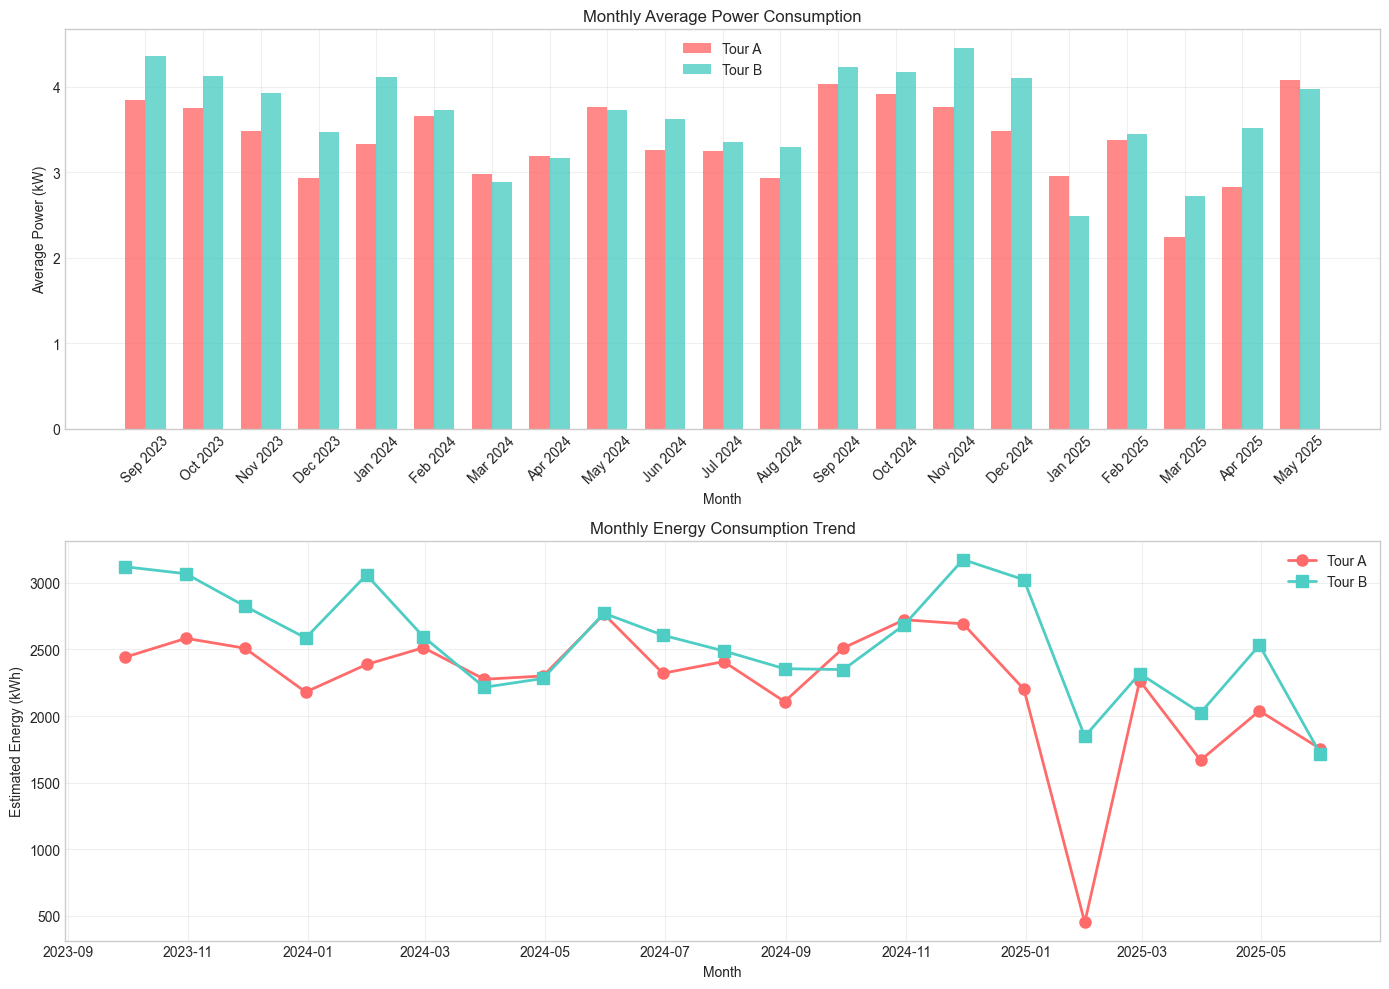

Saved: ./exploration_output\v2_01_monthly_comparison.png


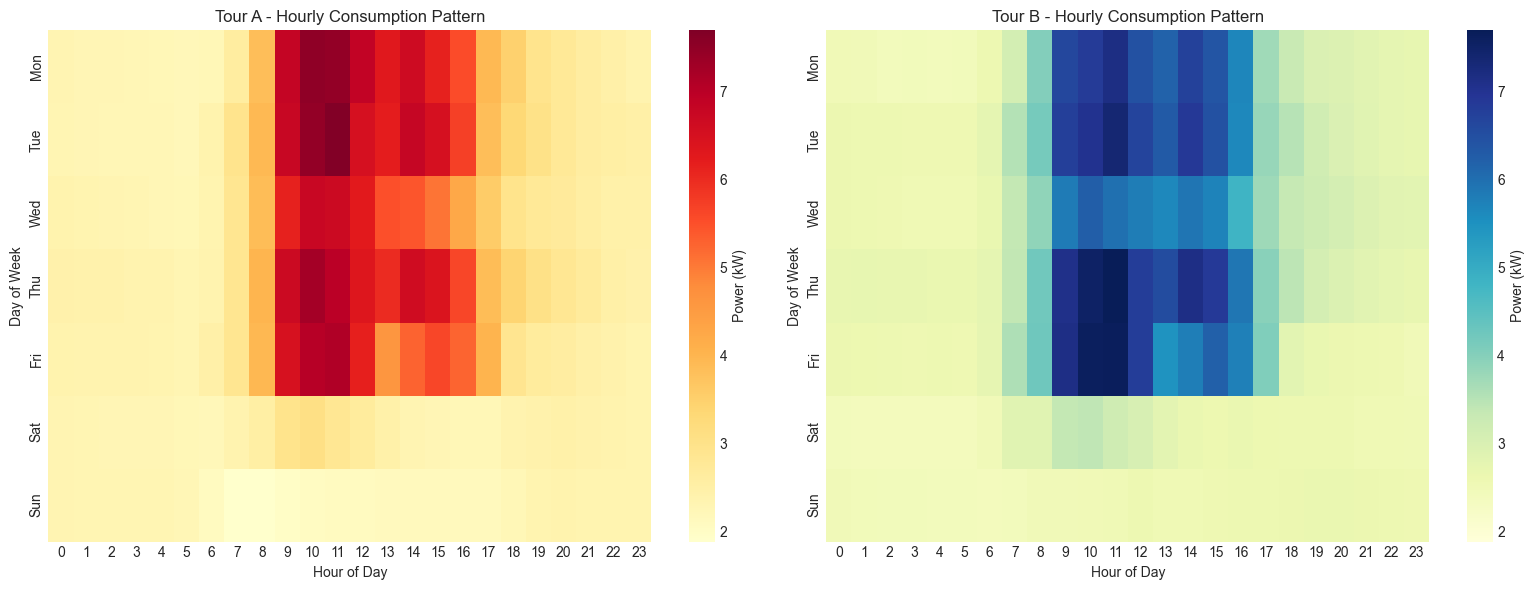

Saved: ./exploration_output\v2_02_heatmap_comparison.png


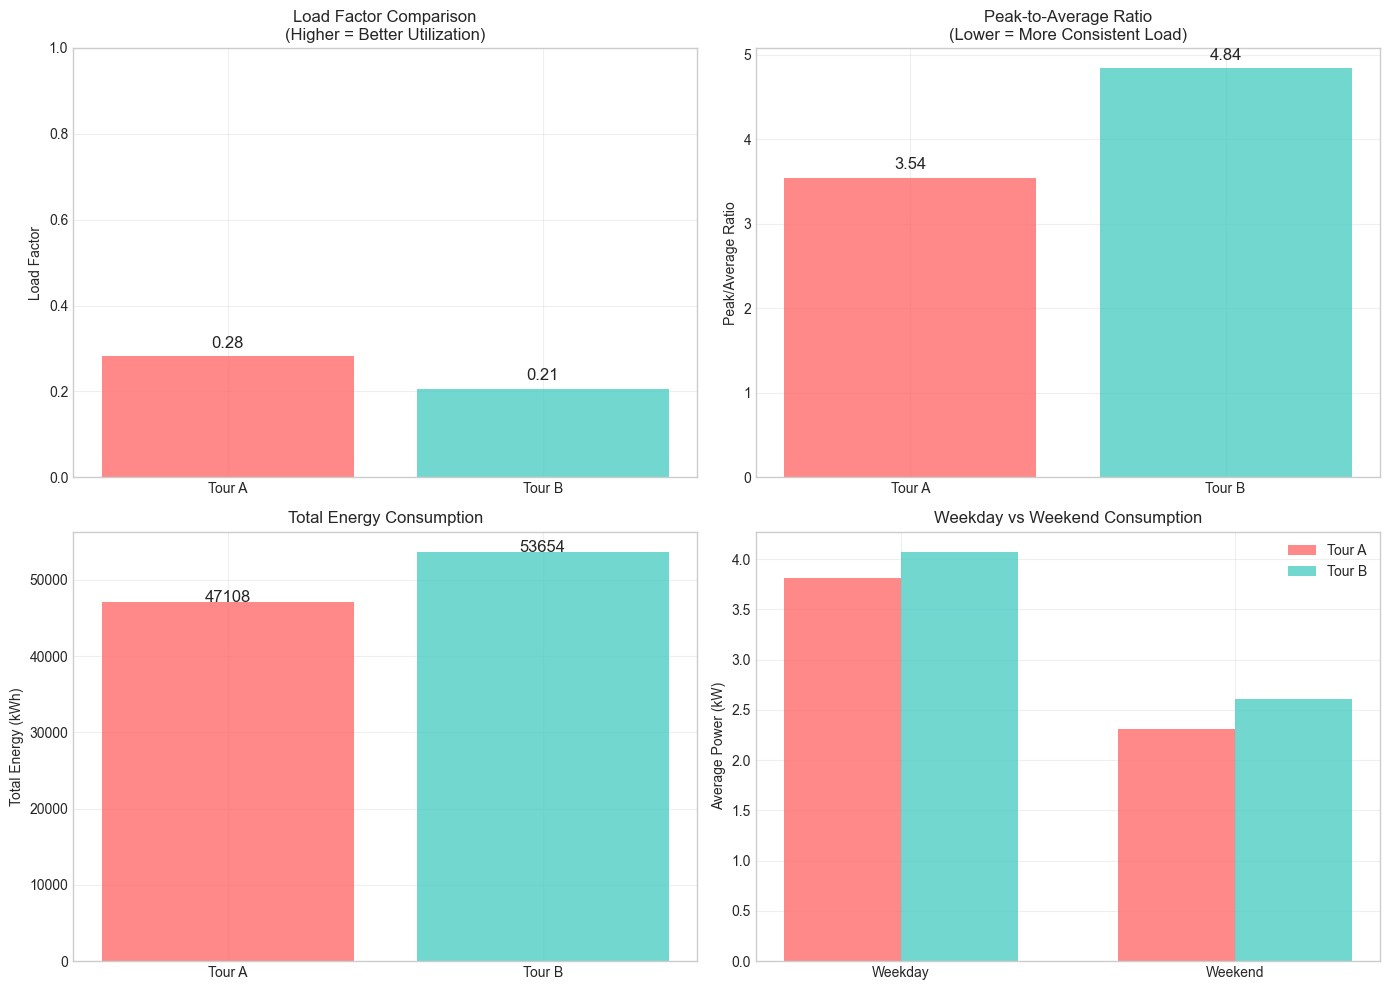

Saved: ./exploration_output\v2_03_efficiency_metrics.png


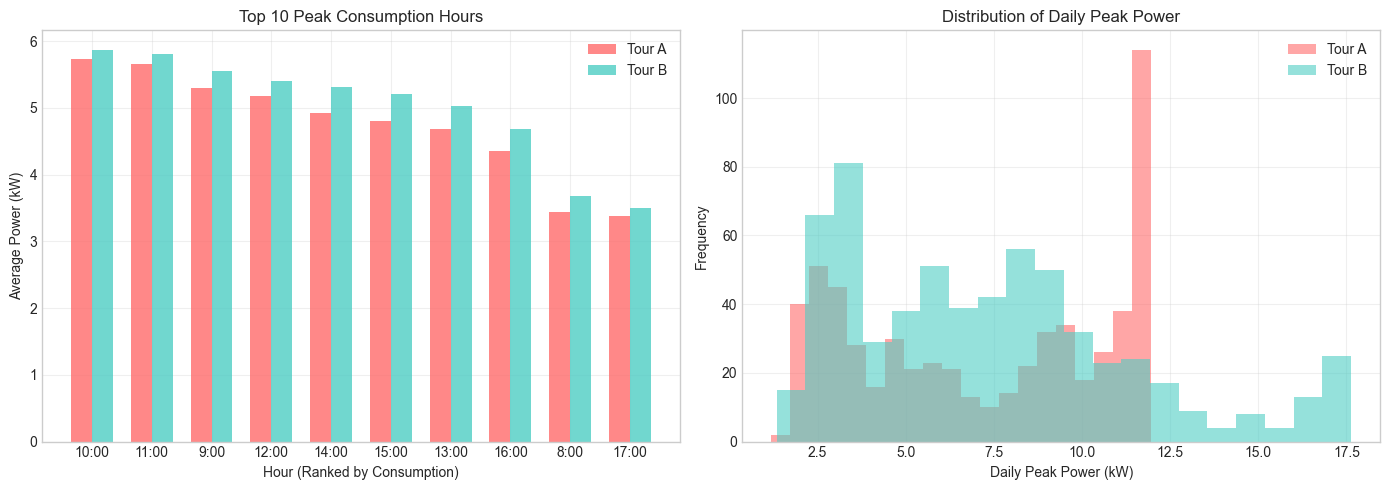

Saved: ./exploration_output\v2_04_peak_analysis.png

DATA EXPLORATION V2 COMPLETE!
Output files saved to: ./exploration_output


In [5]:

"""Main function to run the enhanced data exploration analysis."""
print("=" * 60)
print("DATA EXPLORATION V2: Enhanced Tour A and Tour B Analysis")
print("=" * 60)

# Sort and Clean
df = df[df.index.notna()]
df = df.sort_index()

print(f"Date range: {df.index.min()} to {df.index.max()}")

# Get power columns
print("\n[2/5] Extracting power data...")
power_col_a = get_power_column(df, 'A')
power_col_b = get_power_column(df, 'B')

print(f"Tour A power column: {power_col_a}")
print(f"Tour B power column: {power_col_b}")

if not power_col_a or not power_col_b:
    print("Error: Could not find power columns!")
    exit(1)

# Clean power data
power_a = clean_power_data(df, power_col_a)
power_b = clean_power_data(df, power_col_b)

print(f"Tour A non-null readings: {power_a.notna().sum()} ({100*power_a.notna().mean():.1f}%)")
print(f"Tour B non-null readings: {power_b.notna().sum()} ({100*power_b.notna().mean():.1f}%)")

# Calculate metrics
print("\n[3/5] Calculating metrics...")

metrics_a = {
    'avg_power': power_a.mean(),
    'max_power': power_a.max(),
    'min_power': power_a[power_a > 0].min() if (power_a > 0).any() else 0,
    'std_power': power_a.std(),
    'weekday_avg': power_a[power_a.index.dayofweek < 5].mean(),
    'weekend_avg': power_a[power_a.index.dayofweek >= 5].mean(),
    'data_coverage': 100 * power_a.notna().mean(),
    'load_factor': calculate_load_factor(power_a.dropna()),
    'peak_to_avg': calculate_peak_to_average_ratio(power_a.dropna()),
    'total_energy_kwh': estimate_energy_consumption(power_a)
}

metrics_b = {
    'avg_power': power_b.mean(),
    'max_power': power_b.max(),
    'min_power': power_b[power_b > 0].min() if (power_b > 0).any() else 0,
    'std_power': power_b.std(),
    'weekday_avg': power_b[power_b.index.dayofweek < 5].mean(),
    'weekend_avg': power_b[power_b.index.dayofweek >= 5].mean(),
    'data_coverage': 100 * power_b.notna().mean(),
    'load_factor': calculate_load_factor(power_b.dropna()),
    'peak_to_avg': calculate_peak_to_average_ratio(power_b.dropna()),
    'total_energy_kwh': estimate_energy_consumption(power_b)
}

print(f"\nTour A Metrics:")
print(f"  Average Power: {metrics_a['avg_power']:.2f} kW")
print(f"  Peak Power: {metrics_a['max_power']:.2f} kW")
print(f"  Load Factor: {metrics_a['load_factor']:.3f}")
print(f"  Total Energy: {metrics_a['total_energy_kwh']:.0f} kWh")

print(f"\nTour B Metrics:")
print(f"  Average Power: {metrics_b['avg_power']:.2f} kW")
print(f"  Peak Power: {metrics_b['max_power']:.2f} kW")
print(f"  Load Factor: {metrics_b['load_factor']:.3f}")
print(f"  Total Energy: {metrics_b['total_energy_kwh']:.0f} kWh")

# Generate visualizations
print("\n[4/5] Generating visualizations...")

plot_monthly_comparison(power_a.dropna(), power_b.dropna(),
                        save_path=os.path.join(output_dir, "v2_01_monthly_comparison.png"))

plot_heatmap_comparison(power_a.dropna(), power_b.dropna(),
                        save_path=os.path.join(output_dir, "v2_02_heatmap_comparison.png"))

plot_efficiency_metrics(metrics_a, metrics_b,
                        save_path=os.path.join(output_dir, "v2_03_efficiency_metrics.png"))

plot_peak_analysis(power_a.dropna(), power_b.dropna(),
                    save_path=os.path.join(output_dir, "v2_04_peak_analysis.png"))

print("\n" + "=" * 60)
print("DATA EXPLORATION V2 COMPLETE!")
print(f"Output files saved to: {output_dir}")
print("=" * 60)
